In [25]:
!pip install -q bertopic pandas nltk scikit-learn matplotlib xlwt 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [26]:
import pandas as pd
docs = pd.read_csv('/home/jupyter/WSM/data/papers.csv')
docs = docs.dropna()
docs

,Date,Abstract
0,2015-03-10,Garlic is valued more for its flavoring and us...
1,2015-03-10,The present investigation was undertaken to st...
2,2015-01-01,Upland areas of southeastern U.S. tidal creek ...
3,2014-12-10,The specific activity of 90Sr in milk and vege...
4,2014-06-11,A survey was conducted to evaluate aflatoxin c...
...,...,...
12686,2020-09-29,The gluten-free food market is growing with th...
12687,2020-09-02,Hurricane Sandy made landfall in New Jersey on...
12688,2020-08-28,Prevalent risks in meat value-chains of sub-Sa...
12689,2020-06-03,The presence of metal contaminants in agricult...


In [27]:
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from sentence_transformers import SentenceTransformer
from umap import UMAP
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gmean
import nltk
import re

In [28]:
# Convert the 'Abstract' column to string data type
docs['Abstract'] = docs['Abstract'].astype(str)

# Define a regular expression pattern to match non-Latin characters
non_latin_pattern = re.compile(r'[^\x00-\x7F]')

# Apply the regular expression pattern to the 'Abstract' column
docs = docs[~docs['Abstract'].str.contains(non_latin_pattern)]

In [29]:
from utils.time_utils import group_by_time_unit, time_difference

# Set the time unit for grouping (year, month, or day)
time_unit = 'year'  # Change this to 'year', 'month', or 'day'

# Convert the 'Date' column to datetime and drop invalid dates
docs['Date'] = pd.to_datetime(docs['Date'], errors='coerce')
docs.dropna(subset=['Date'], inplace=True)

# Group data based on the selected time unit
docs['Time'] = group_by_time_unit(docs, time_unit)

In [30]:
# Prepare the abstracts
abstracts = docs["Abstract"].astype('str')
text = abstracts.tolist()

In [31]:
# Topic Model
sentence_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = sentence_model.encode(text, show_progress_bar=False)
cluster_model = AgglomerativeClustering(distance_threshold=0.2, n_clusters=None)

topic_model = BERTopic(hdbscan_model=cluster_model).fit(text, embeddings)
topic_info = topic_model.get_topic_info()

doc_info = topic_model.get_document_info(text)
doc_info["ID"] = doc_info.index
doc_info["Time"] = docs["Time"].tolist()

In [33]:
# DOV_calculation
from utils.dov_calculator import dov_calc

wsm_dov = dov_calc(doc_info, topic_info, time_unit, tw=0.05)
wsm_dov

NameError: name 'time_difference' is not defined

In [28]:
wsm_dov.to_csv('data/wsm_dov.csv', index=False)

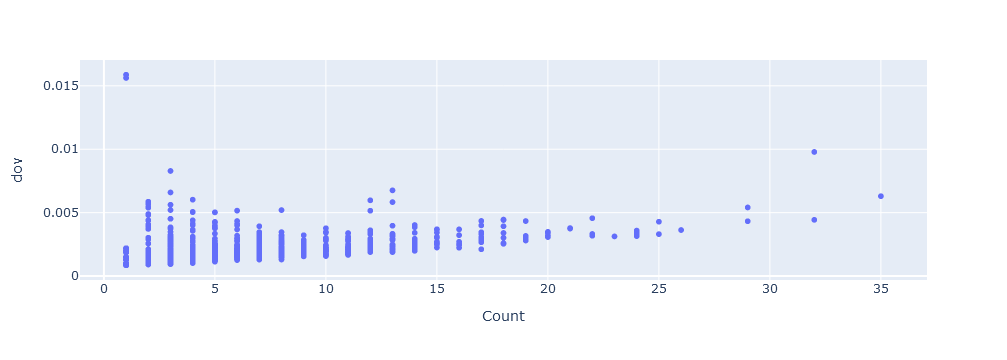

In [29]:
import plotly.express as px

# Create the scatter plot using Plotly
fig = px.scatter(wsm_dov, x='Count', y='dov', hover_data=['Name'])

# Show the plot
fig.show()

In [34]:
# Set the desired range for 'dov' and 'frequency'
dov_min = 0.004
count_min = 3
count_max = 6

# Filter the DataFrame based on the range of values
weak_signal_df = wsm_dov[(wsm_dov['dov'] >= dov_min) & (wsm_dov['Count'] >= count_min) & (wsm_dov['Count'] <= count_max)]

# Get the values from the 'term' column in the filtered DataFrame
weak_signals = weak_signal_df['Name'].values.tolist()
weak_signal_df

,Name,dov,Topic,Count,Representation,Representative_Docs
3,582_foragers_social_collective_colony,0.004269,582,5,"[foragers, social, collective, colony, nestmat...",[Foraging is a result of innate and acquired m...
7,700_pregnancy_hypospadias_glucose_discourses,0.004397,700,4,"[pregnancy, hypospadias, glucose, discourses, ...",[Overweight and obesity pre pregnancy or durin...
11,924_microscopically_bioinformaticsenabled_libr...,0.008287,924,3,"[microscopically, bioinformaticsenabled, libra...",[Since the advent of the use of matrix-assiste...
28,678_pgamended_peppers_ferralsols_moderately,0.005038,678,4,"[pgamended, peppers, ferralsols, moderately, p...",[Lead (Pb) contamination of soil poses severe ...
33,482_afb1_aflatoxin_indonesia_cancer,0.004123,482,6,"[afb1, aflatoxin, indonesia, cancer, ngkg, 001...",[This mini review article described the exposu...
35,442_lenses_device_maude_sentinel,0.004003,442,6,"[lenses, device, maude, sentinel, stroke, comp...",[All contact lenses (corrective/noncorrective)...
61,453_sanguineus_sachet_salivary_am,0.005160,453,6,"[sanguineus, sachet, salivary, am, ivermectin,...",[The purpose of this study was to develop an a...
74,847_buttonwood_site_stem_cadmium,0.006593,847,3,"[buttonwood, site, stem, cadmium, leaf, chicor...",[Soil contaminated with cadmium presents a pot...
93,690_sfr_bottles_asepticuht_1011,0.004046,690,4,"[sfr, bottles, asepticuht, 1011, stearothermop...",[Aseptic ultra-high-temperature (UHT)-type pro...
110,656_timetemperature_git_options_simulated,0.005065,656,4,"[timetemperature, git, options, simulated, buf...",[Even though a plethora of barriers are employ...


In [35]:
weak_signal_df.to_csv('data/weak_signal_df.csv', index=False)